# Deep Learning - Final Project

### Student 1: Shachar Hananya 324165133
### Student 2: Kanna Nahir 211319876


# Import Libraries

In [1]:
import torch
from torch import nn
import numpy as np
from PIL import Image
import pickle as pkl
from matplotlib import pyplot as plt

from torchvision import models

Define the device and the required image size.

In [2]:
IMG_SIZE = 320, 320
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load and Upload Data

Load the first pretrained model, the hyper-parameters for the second model training, and a Monet painting for the new style of the  uploaded photo.

In [4]:
!gdown --id 1Fx7XuwbpxGRLJAsqzW-X0_ZunSUjz1b0 # load a monet image
!gdown --id 10OiXLJqAEg-ldQ4eE-rBCwdCSX1kDh18 # load model 1
# !gdown --id 12ScJp4uX7GphhQ7xYV8hW1_cGPYdEN6G # load hyper-parameters for model 2
!gdown --id 16N2YrGWS1-fnR8srziL9hZPK09SgFRaP # load hyper-parameters for model 2

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Fx7XuwbpxGRLJAsqzW-X0_ZunSUjz1b0
To: /content/monet_example.jpg
100% 13.3k/13.3k [00:00<00:00, 56.0MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10OiXLJqAEg-ldQ4eE-rBCwdCSX1kDh18
To: /content/first_model.pkl
100% 20.9M/20.9M [00:00<00:00, 102MB/s] 
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.goo

Plot the example Monet painting.

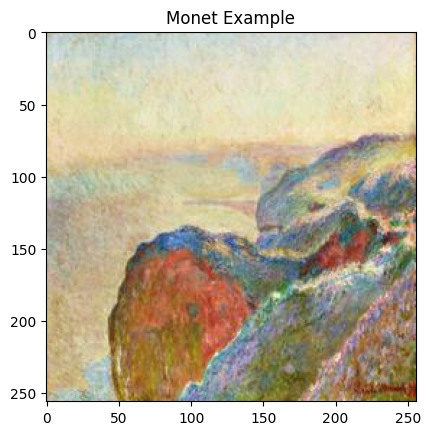

In [33]:
plt.imshow(Image.open("monet_example.jpg"))
plt.title("Monet Example")
plt.show()

Upload the photo to be transfered to a Monet style.

In [46]:
from google.colab import files
uploaded = files.upload()

Saving fe65abaafd.jpg to fe65abaafd.jpg


Extract the file name of the uploaded photo.


In [47]:
filename = list(uploaded.keys())[0]
filename

'fe65abaafd.jpg'

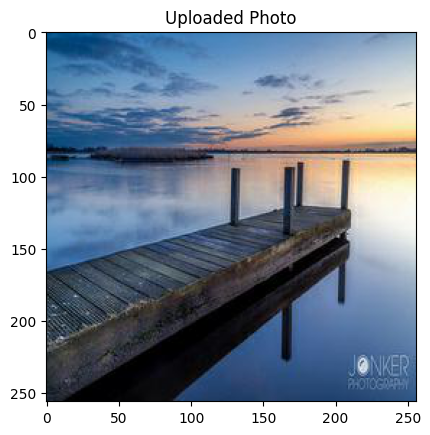

In [48]:
plt.imshow(Image.open(filename))
plt.title("Uploaded Photo")
plt.show()

# First Model

## Pre and Post Processing

### Pre-Processing Functions

Define convertors between PIL images to model input, and back.

In [49]:
pil2inp_first = lambda img: (img.reshape(-1, 3, *IMG_SIZE) - 127.5) / 127.5
inp2pil_first = lambda img: img.reshape(-1, *IMG_SIZE, 3) * 127.5 + 127.5

Convert a file name into a proper model input.

In [50]:
def filename2inp_first(fn):
  img = torch.from_numpy(np.array(Image.open(fn).resize(IMG_SIZE)))
  img = pil2inp_first(img)
  return img

### Post-Processing Function

In [51]:
model_out2img_first = lambda img: inp2pil_first(img).long().cpu().detach().numpy()[0]

### Model Classes

Required for loading the pretrained model.


In [52]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=4).to(DEVICE)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2).to(DEVICE)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, stride=2).to(DEVICE)

        self.deconv1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2).to(DEVICE)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2).to(DEVICE)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=4).to(DEVICE)

        self.batch_norm1 = nn.BatchNorm2d(64).to(DEVICE)
        self.batch_norm2 = nn.BatchNorm2d(128).to(DEVICE)
        self.batch_norm3 = nn.BatchNorm2d(256).to(DEVICE)
        self.batch_norm4 = nn.BatchNorm2d(128).to(DEVICE)
        self.batch_norm5 = nn.BatchNorm2d(64).to(DEVICE)
        self.batch_norm6 = nn.BatchNorm2d(3).to(DEVICE)

        self.leaky_relu = nn.LeakyReLU()


    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.leaky_relu(x)

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu(x)

        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.leaky_relu(x)

        x = self.deconv1(x)
        x = self.batch_norm4(x)
        x = self.leaky_relu(x)

        x = self.deconv2(x)
        x = self.batch_norm5(x)
        x = self.leaky_relu(x)

        x = self.deconv3(x)
        x = self.batch_norm6(x)
        x = nn.Tanh()(x)

        return x

In [53]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=4, bias=False)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, bias=False)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, stride=2, bias=False)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, bias=False)

        self.batch_norm1 = nn.BatchNorm2d(128)
        self.batch_norm2 = nn.BatchNorm2d(256)
        self.batch_norm3 = nn.BatchNorm2d(512)

        self.batch_norm4 = nn.BatchNorm2d(64)


        self.leaky_relu = nn.LeakyReLU()


    def forward(self, x):
        x = self.conv1(x)

        # x = self.batch_norm4(x) # added

        x = self.leaky_relu(x)

        x = self.conv2(x)
        x = self.batch_norm1(x)
        x = self.leaky_relu(x)

        x = self.conv3(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu(x)

        x = self.conv4(x)
        x = self.batch_norm3(x)
        x = self.leaky_relu(x)

        x = self.conv5(x)

        x = nn.Sigmoid()(x)
        return x


In [54]:
class CycleGAN(nn.Module):
    def __init__(self):
        super().__init__()

        self.G = Generator().to(DEVICE)
        self.F = Generator().to(DEVICE)
        self.D_X = Discriminator().to(DEVICE)
        self.D_Y = Discriminator().to(DEVICE)

    def forward(self, x, y):
        x2y = self.G(x)
        y2x = self.F(y)
        x2y2x = self.F(x2y)
        y2x2y = self.G(y2x)

        x2y2x2y = self.G(x2y2x)
        y2x2y2x = self.F(y2x2y)

        x2y_disc = self.D_Y(x2y)
        y2x_disc = self.D_X(y2x)

        return x2y, y2x, x2y2x, y2x2y, x2y2x2y, y2x2y2x, x2y_disc, y2x_disc

## Main Function


In [55]:
def test_first_model():
    x = filename2inp_first(filename).to(DEVICE)

    x2y = first_model.G(x)

    orig_img = model_out2img_first(x)
    gen_img = model_out2img_first(x2y)

    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.title("Original")

    plt.subplot(1, 2, 2)
    plt.imshow(gen_img)
    plt.title("Genenerated")

    plt.tight_layout()
    plt.show()

Load the pretrained model

In [56]:
first_model = pkl.load(open("first_model.pkl", "rb"))
first_model.to(DEVICE).eval()

CycleGAN(
  (G): Generator(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
    (conv2): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    (deconv1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (deconv3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(4, 4))
    (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm6): BatchNorm2d(3, eps=1e-05, momentum=0.1, 

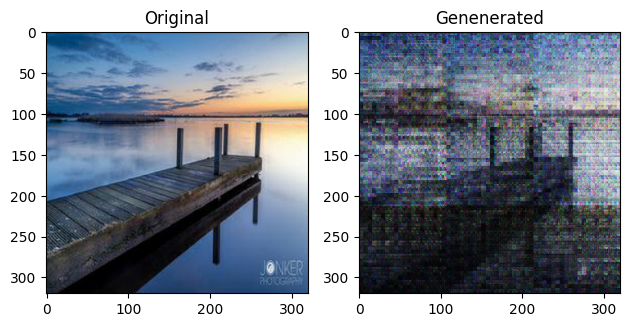

In [57]:
test_first_model()

# Second Model

Since the Neural Style Transfer model is suitable for specific content and style images, we have no chice but to train a new model here for the relevant inputs. Either way, we provide a one-click training and evaluation phases, such that the user will have the same UI experience, except for the relatively long runnung time (compared with a pretrained model).

## Pre and Post Processing

### Pre-Processing Functions

Define convertors between PIL images to model input, and back.

In [58]:
pil2inp_second = lambda img: (img.reshape(-1, 3, *IMG_SIZE) - 127.5) / 127.5
inp2pil_second = lambda img: img.reshape(-1, *IMG_SIZE, 3) * 127.5 + 127.5

In [59]:
def filename2inp_second(fn):
  img = torch.from_numpy(np.array(Image.open(fn).resize(IMG_SIZE)))
  img = img.resize(1, 3, *IMG_SIZE).float() / 255
  return img

### Post-Processing Function

Convert a file name into a proper  model input.

In [60]:
model_out2img_second = lambda img: img.resize(*IMG_SIZE, 3).squeeze(0).cpu().detach().numpy()

### Model Class


In [61]:
class NST(nn.Module):
    def __init__(self):
        super(NST, self).__init__()
        self.feats2calc = [0, 5, 10, 19, 28]
        self.vgg_model = models.vgg19(pretrained=True).features[:self.feats2calc[-1] + 1]

    def forward(self, x):
        features = []

        for i, layer in enumerate(self.vgg_model):
            x = layer(x)
            if i in self.feats2calc:
                features.append(x)

        return features

## Main Function

In [62]:
mse_loss = nn.MSELoss()

content_loss_func = lambda cf, gf: mse_loss(cf, gf)


def style_loss_func(sf, gf):
    style_loss = []

    a, b, c, d = gf.shape

    g_feats = gf.view(a * b, c * d)
    G = torch.mm(g_feats, g_feats.t())

    s_feats = sf.view(a * b, c * d)
    S = torch.mm(s_feats, s_feats.t())

    style_loss = mse_loss(G, S)

    return style_loss

In [63]:
def train_second_model(model, con_img, st_img, gen_img, hp):
    lr = hp["LR"]
    n_epochs = hp["N_EPOCHS"]
    lam_style = hp["LAM_STYLE"]

    optimizer = torch.optim.Adam([gen_img], lr=lr)

    for e in range(1, 1 + n_epochs):
        content_feats = model(con_img)
        style_feats = model(st_img)
        gen_feats = model(gen_img)

        content_loss = style_loss = 0

        for cf, sf, gf in zip(content_feats, style_feats, gen_feats):
            content_loss += content_loss_func(cf, gf)
            style_loss += style_loss_func(sf, gf)

        loss = content_loss + lam_style * style_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return con_img, st_img, gen_img



In [64]:
def test_second_model(hp):
    orig_img = filename2inp_second(filename).to(DEVICE)
    style_img = filename2inp_second("monet_example.jpg").to(DEVICE)
    gen_img = orig_img.clone().requires_grad_(True)

    model = NST().to(DEVICE).eval()

    orig_img, style_img, gen_img = train_second_model(model, orig_img, style_img, gen_img, hp)

    orig_img = model_out2img_second(orig_img)
    style_img = model_out2img_second(style_img)
    gen_img = model_out2img_second(gen_img)

    plt.subplot(1, 3, 1)
    plt.imshow(orig_img)
    plt.title("Original")

    plt.subplot(1, 3, 2)
    plt.imshow(style_img)
    plt.title("Style")

    plt.subplot(1, 3, 3)
    plt.imshow(gen_img)
    plt.title("Genenerated")

    plt.tight_layout()
    plt.show()

Load the hyper-parameters for the second model training.

In [65]:
second_model_hp = pkl.load(open("second_model_hp.pkl", "rb"))

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 85.8MB/s]


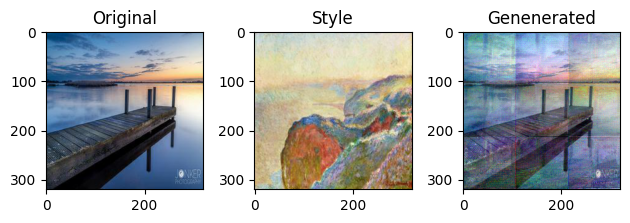

In [66]:
test_second_model(second_model_hp)